In [1]:
import os
import sys
import time
import math
import keras
import datetime
import itertools
import numpy as np
import pandas as pd

from keras.layers import * 
from keras.models import Model
from keras import optimizers
from keras.utils import multi_gpu_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Data parameters
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

# Parameters of the model
PRED_HORIZON = 3
PRED_STEPS = 2
SEQ_LEN = 16 #50 #60 #72 #8
DYNAMIC_FEATURES = ['deal', 'feat', 'month', 'week_of_month'] #['week', 'week_of_month'] #['profit', 'feat']
#DYNAMIC_FEATURES += ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', \
#                     'price7', 'price8', 'price9', 'price10', 'price11']
STATIC_FEATURES = ['store', 'brand']

In [4]:
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def gen_sequence(df, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Reshape features into an array of dimension (time steps, features).  
    
    Args:
        df (Dataframe): Time series data of a specific (store, brand) combination
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        A generator object for iterating all the feature sequences
    """
    data_array = df[seq_cols].values
    if end_timestep is None:
        end_timestep = df.shape[0]
    for start, stop in zip(range(start_timestep, end_timestep-seq_len+2), range(start_timestep+seq_len, end_timestep+2)):
        yield data_array[start:stop, :]

def gen_sequence_array(df_all, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Combine feature sequences for all the combinations of (store, brand) into an 3d array.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        seq_array (Numpy Array): An array of the feature sequences of all stores and brands    
    """
    seq_gen = (list(gen_sequence(df_all[(df_all['store']==cur_store) & (df_all['brand']==cur_brand)], \
                                 seq_len, seq_cols, start_timestep, end_timestep)) \
              for cur_store, cur_brand in itertools.product(df_all['store'].unique(), df_all['brand'].unique()))
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    return seq_array

def static_feature_array(df_all, total_timesteps, seq_cols):
    """Generate an arary which encodes all the static features.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        total_timesteps (Integer): Total number of training samples for each store and brand
        seq_cols (List): A list of names of the static feature columns (e.g., store index)
        
    Return:
        fea_array (Numpy Array): An array of static features of all stores and brands
    """
    fea_df = data_filled.groupby(['store', 'brand']). \
                         apply(lambda x: x.iloc[:total_timesteps,:]). \
                         reset_index(drop=True)
    fea_array = fea_df[seq_cols].values
    return fea_array

def normalize_dataframe(df, seq_cols, scaler=MinMaxScaler()):
    """Normalize a subset of columns of a dataframe.
    
    Args:
        df (Dataframe): Input dataframe 
        seq_cols (List): A list of names of columns to be normalized
        scaler (Scaler): A scikit learn scaler object
    
    Returns:
        df_scaled (Dataframe): Normalized dataframe
    """
    cols_fixed = df.columns.difference(seq_cols)
    df_scaled = pd.DataFrame(scaler.fit_transform(df[seq_cols]), 
                            columns=seq_cols, index=df.index)
    df_scaled = pd.concat([df[cols_fixed], df_scaled], axis=1)
    return df_scaled, scaler

def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'prediction', 'actual']].set_index('week')
    plt.figure()
    ax = subset.plot()
    ax.set_ylim(bottom=0)
    ax.legend(labels=['predicted', 'actual'])

In [5]:
# Model definition
def create_dcnn_model(seq_len, kernel_size=2, n_filters=3, n_input_series=1, n_outputs=1):
    # Sequential input
    seq_in = Input(shape=(seq_len, n_input_series))
    # Categorical input
    cat_fea_in = Input(shape=(2,), dtype='uint8')
    store_id = Lambda(lambda x: x[:, 0, None])(cat_fea_in)
    brand_id = Lambda(lambda x: x[:, 1, None])(cat_fea_in)
    store_embed = Embedding(MAX_STORE_ID+1, 7, input_length=1)(store_id)
    brand_embed = Embedding(MAX_BRAND_ID+1, 4, input_length=1)(brand_id)
    
    # Dilated convolutional layers
    c1 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=1, 
                padding='causal', activation='relu')(seq_in)
    c2 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=2, 
                padding='causal', activation='relu')(c1)
    c3 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=4, 
                padding='causal', activation='relu')(c2)
    # Skip connections
    c4 = concatenate([c1, c3])
    # Output of convolutional layers 
    conv_out = Conv1D(8, 1, activation='relu')(c4)
    conv_out = Dropout(0.1)(conv_out) #Dropout(0.25)(conv_out)
    conv_out = Flatten()(conv_out)
    
    # Concatenate with categorical features
    x = concatenate([conv_out, Flatten()(store_embed), Flatten()(brand_embed)])
    #x = BatchNormalization()(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(0.25)(x)
    x = Dense(16, activation='relu')(x)
    #x = Dropout(0.6)(x)
    output = Dense(n_outputs, activation='linear')(x)
    
    model = Model(inputs=[seq_in, cat_fea_in], outputs=output)
    adam = optimizers.Adam(lr=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    return model

model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=4, n_outputs=PRED_STEPS)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 4)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 3)        27          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16, 3)        21          conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 16, 3)        21          conv1d_2[0][0]                   
__________________________________________________________________________________________________
concatenat

In [6]:
%%time
pred_all = []
combined_all = []
metric_all = []
for r in range(12): #range(bs.NUM_ROUNDS):
    print('---- Round ' + str(r+1) + ' ----')
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    #print(train_df.head(3))
    #print('')
    train_df = train_df[['store', 'brand', 'week', 'profit', 'move']]
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, 'aux_round_'+str(r+1)+'.csv'))  
    data_filled = pd.merge(data_filled, aux_df, how='left',  # Get future price, deal, and advertisement info
                            on=['store', 'brand', 'week'])
    #print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    #print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    #print(data_filled.head(3))
    #print('')
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x-1)*7))
    #data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)  
    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(['store','brand','week'])
    data_scaled, min_max_scaler = normalize_dataframe(data_filled, cols_normalize)
    #data_scaled.head()

    # Create sequence array for 'move'
    start_timestep = 0
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-PRED_HORIZON
    train_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep, end_timestep)
    #train_input1.shape

    # Create sequence array for other dynamic features
    start_timestep = PRED_HORIZON
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
    train_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep, end_timestep)
    #train_input2.shape

    seq_in = np.concatenate((train_input1, train_input2), axis=2)
    #seq_in.shape

    # Create array of static features
    total_timesteps = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-SEQ_LEN-PRED_HORIZON+2
    cat_fea_in = static_feature_array(data_filled, total_timesteps, ['store', 'brand'])
    #cat_fea_in.shape

    # Create training output
    start_timestep = SEQ_LEN+PRED_HORIZON-PRED_STEPS
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
    train_output = gen_sequence_array(data_filled, PRED_STEPS, ['move'], start_timestep, end_timestep)
    train_output = np.squeeze(train_output)
    #train_output.shape

    # Create model
    if r >= 0:
        model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=1+len(DYNAMIC_FEATURES), n_outputs=PRED_STEPS)
        # Convert to GPU model
        try:
            model = multi_gpu_model(model)
            print('Training using multiple GPUs..')
        except:
            print('Training using single GPU or CPU..')

        adam = optimizers.Adam(lr=0.02)
        #model.compile(loss='mse', optimizer=adam, metrics=['mae'])
        model.compile(loss='mape', optimizer=adam, metrics=['mape', 'mae'])
        #model.fit([seq_in, cat_fea_in], train_output, epochs=2, batch_size=2, validation_data=([seq_in, cat_fea_in], train_output))
        #model.fit([seq_in, cat_fea_in], train_output, epochs=5, batch_size=16, validation_split=0.05)
        model.fit([seq_in, cat_fea_in], train_output, epochs=3, batch_size=64, validation_split=0.05)
        #model.fit([seq_in, cat_fea_in], train_output, epochs=1, batch_size=16)
        
    # Get expected test output
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)

    exp_output = data_filled[data_filled.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    exp_output = exp_output[['store', 'brand', 'week']]
    exp_output = pd.merge(exp_output, test_df, on=['store', 'brand', 'week'], how='left')

    start_timestep = 0
    end_timestep = PRED_STEPS-1
    exp_test_output = gen_sequence_array(exp_output, PRED_STEPS, ['actual'], start_timestep, end_timestep)
    exp_test_output = np.squeeze(exp_test_output)

    # Get inputs for prediction
    start_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN - PRED_HORIZON + PRED_STEPS
    end_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK + PRED_STEPS - 1 - PRED_HORIZON
    test_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep, end_timestep)

    start_timestep = bs.TEST_END_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN + 1
    end_timestep = bs.TEST_END_WEEK_LIST[r] - bs.TRAIN_START_WEEK
    test_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep, end_timestep)

    seq_in = np.concatenate((test_input1, test_input2), axis=2)

    total_timesteps = 1
    cat_fea_in = static_feature_array(data_filled, total_timesteps, ['store', 'brand'])

    pred = np.round(model.predict([seq_in, cat_fea_in]))
    
    # Create dataframe for submission
    pred_df = exp_output.sort_values(['store', 'brand', 'week']).\
                         loc[:,['store', 'brand', 'week']].\
                         reset_index(drop=True)
    pred_df['weeks_ahead'] = pred_df['week'] - bs.TRAIN_END_WEEK_LIST[r]
    pred_df['round'] = r+1
    pred_df['prediction'] = np.reshape(pred, (pred.size, 1))
    combined = pd.merge(pred_df, test_df, on=['store', 'brand', 'week'], how='left')

    pred_all.append(pred_df)
    combined_all.append(combined)
    cur_metric = np.nanmean(np.abs(pred-exp_test_output)/exp_test_output)*100
    print('Current MAPE is {}'.format(cur_metric))
    metric_all.append(cur_metric)

---- Round 1 ----
Training using multiple GPUs..
Train on 67653 samples, validate on 3561 samples
Epoch 1/3
67653/67653 [==============================] - 12s 171us/step - loss: 54.6646 - mean_absolute_percentage_error: 54.6646 - mean_absolute_error: 7564.6800 - val_loss: 59.1373 - val_mean_absolute_percentage_error: 59.1373 - val_mean_absolute_error: 9112.5359
Epoch 2/3
67653/67653 [==============================] - 10s 144us/step - loss: 47.5668 - mean_absolute_percentage_error: 47.5668 - mean_absolute_error: 7035.9081 - val_loss: 56.1135 - val_mean_absolute_percentage_error: 56.1135 - val_mean_absolute_error: 8786.2286
Epoch 3/3
67653/67653 [==============================] - 10s 144us/step - loss: 46.2323 - mean_absolute_percentage_error: 46.2323 - mean_absolute_error: 6891.7327 - val_loss: 51.0271 - val_mean_absolute_percentage_error: 51.0271 - val_mean_absolute_error: 8192.4915
Current MAPE is 52.2356390953064
---- Round 2 ----
Training using multiple GPUs..
Train on 69388 samples

81530/81530 [==============================] - 12s 148us/step - loss: 43.2844 - mean_absolute_percentage_error: 43.2844 - mean_absolute_error: 6322.1160 - val_loss: 47.0397 - val_mean_absolute_percentage_error: 47.0397 - val_mean_absolute_error: 7452.7959
Current MAPE is 43.51357817649841
---- Round 10 ----
Training using multiple GPUs..
Train on 83265 samples, validate on 4383 samples
Epoch 1/3
83265/83265 [==============================] - 14s 170us/step - loss: 54.0128 - mean_absolute_percentage_error: 54.0128 - mean_absolute_error: 7233.4998 - val_loss: 56.6623 - val_mean_absolute_percentage_error: 56.6623 - val_mean_absolute_error: 8464.2478
Epoch 2/3
83265/83265 [==============================] - 12s 147us/step - loss: 47.5870 - mean_absolute_percentage_error: 47.5870 - mean_absolute_error: 6753.7089 - val_loss: 54.3615 - val_mean_absolute_percentage_error: 54.3615 - val_mean_absolute_error: 8254.0065
Epoch 3/3
83265/83265 [==============================] - 12s 148us/step - loss:

In [7]:
metric_all

[52.2356390953064,
 49.731916189193726,
 47.59567975997925,
 46.534428000450134,
 46.2046355009079,
 46.65350317955017,
 47.62013256549835,
 43.51288378238678,
 43.51357817649841,
 46.16706371307373,
 44.26161050796509,
 49.23354983329773]

In [8]:
np.mean(metric_all)

46.93871835867564

In [9]:
# Generate submission
submission = pd.concat(pred_all, axis=0).reset_index(drop=True)
submission = submission[['round', 'store', 'brand', 'week', 'weeks_ahead', 'prediction']]
#submission.to_csv('submission_seed_1.csv', index=False)
#submission.to_csv('submission_seed_2.csv', index=False)
#submission.to_csv('submission_seed_3.csv', index=False)
#submission.to_csv('submission_seed_4.csv', index=False)
submission.to_csv('submission_seed_5.csv', index=False)
submission.head()

,round,store,brand,week,weeks_ahead,prediction
0,1,2,1,137,2,8031.0
1,1,2,1,138,3,7933.0
2,1,2,2,137,2,6388.0
3,1,2,2,138,3,6974.0
4,1,2,3,137,2,1052.0


<Figure size 432x288 with 0 Axes>

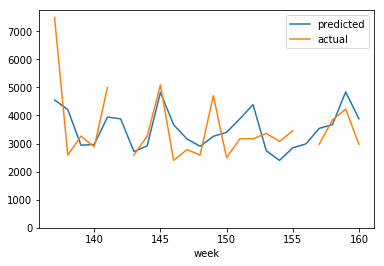

<Figure size 432x288 with 0 Axes>

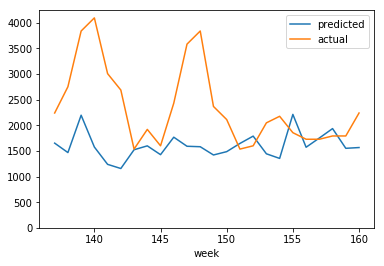

<Figure size 432x288 with 0 Axes>

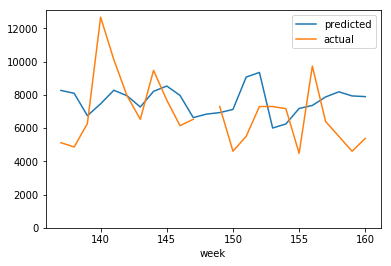

<Figure size 432x288 with 0 Axes>

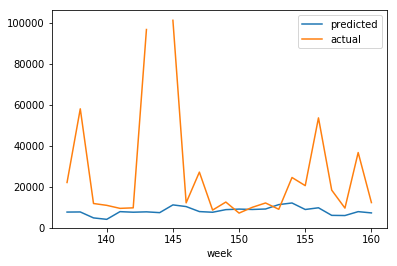

<Figure size 432x288 with 0 Axes>

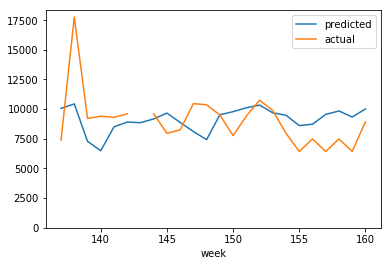

In [10]:
# Visualize forecast results
import random
import matplotlib.pyplot as plt
%matplotlib inline

results = pd.concat(combined_all, axis=0)
#random.seed(2)
for _ in range(5):
    store = random.choice(results['store'].unique())
    brand = random.choice(results['brand'].unique())
    plot_result(results, store, brand)

In [11]:
exp_test_output[0,]

array([16192.,  5824.], dtype=float32)

In [12]:
test_df.head()

,store,brand,week,constant,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,deal,feat,profit,actual
0,2,1,159,1,0.043594,0.051979,0.046719,0.030720,0.041719,0.036354,0.040469,0.031094,0.026250,0.023281,0.031172,1,1.0,33.338814,16192
1,2,1,160,1,0.046406,0.041563,0.046719,0.043125,0.034219,0.036910,0.040469,0.032344,0.037344,0.028438,0.031172,1,0.0,39.135824,5824
2,2,2,159,1,0.043594,0.051979,0.046719,0.030720,0.041719,0.036354,0.040469,0.031094,0.026250,0.023281,0.031172,0,0.0,33.417143,5376
3,2,2,160,1,0.046406,0.041563,0.046719,0.043125,0.034219,0.036910,0.040469,0.032344,0.037344,0.028438,0.031172,1,0.0,16.766977,8256
4,2,3,159,1,0.043594,0.051979,0.046719,0.030720,0.041719,0.036354,0.040469,0.031094,0.026250,0.023281,0.031172,0,0.0,34.036250,1664


In [13]:
#train_sub = data_filled[(data_filled.store==2) & (data_filled.brand==1)].reset_index(drop=True)
train_sub = data_scaled[(data_scaled.store==2) & (data_scaled.brand==1)].reset_index(drop=True)

In [14]:
np.array(train_sub.loc[58:117,'move'])

array([0.0126865 , 0.03055481, 0.01885107, 0.01885107, 0.01885107,
       0.00571786, 0.05494505, 0.00777272, 0.01250782, 0.00830876,
       0.01072099, 0.00938086, 0.00938086, 0.00866613, 0.00732601,
       0.01277584, 0.0100956 , 0.04770839, 0.00991691, 0.00839811,
       0.00705798, 0.01152506, 0.02465827, 0.01822568, 0.01822568,
       0.01357992, 0.00482444, 0.00759403, 0.00929152, 0.02814259,
       0.00696864, 0.06075226, 0.03582596, 0.04431341, 0.02885732,
       0.02108461, 0.0391316 , 0.01724292, 0.00741535, 0.01357992,
       0.02358617, 0.01152506, 0.00955955, 0.00964889, 0.01000625,
       0.07183061, 0.03100152, 0.06432592, 0.00598588, 0.02403288,
       0.00786206, 0.0094702 , 0.00607523, 0.00643259, 0.00991691,
       0.00696864, 0.01858304, 0.01125704, 0.02707049, 0.01393728])

In [15]:
np.squeeze(test_input1[0,])

array([0.01000625, 0.07183061, 0.03100152, 0.06432592, 0.00598588,
       0.02403288, 0.00786206, 0.0094702 , 0.00607523, 0.00643259,
       0.00991691, 0.00696864, 0.01858304, 0.01125704, 0.02707049,
       0.01393728], dtype=float32)